# Quickstart into TigerControl

Welcome to TigerControl! This is a short tutorial to get you started with the framework. First, start by installing the package from GitHub using pip or pip3.

In [0]:
!git clone https://github.com/johnhallman/tigercontrol.git
!pip install -e tigercontrol

Import TigerControl as with any other Python package

In [0]:
import tigercontrol
tigercontrol.set_key(0) # random seeding makes TigerControl deterministic

You are now ready to get started!

# The Environment class
The Environment class is the abstraction used to implement control and time series tasks. TigerControl comes pre-loaded with several classical environments (both simulated and real world data) such as ARMA time series or linear dynamical systems. Below we demonstrate how to initialize a environment and step through the simulated time series generated by an ARMA. The initialize() controller returns the initial observation. We can also query the hidden state of the system.


Hidden state: (DeviceArray([0.59467399, 0.38323703, 0.63343   ], dtype=float32), DeviceArray([ 0.15954755, -0.01773814,  0.12359917], dtype=float32))


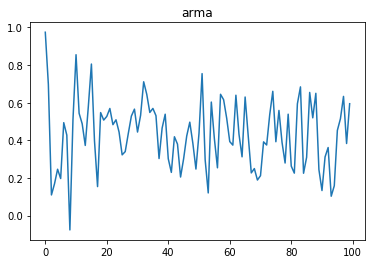

In [0]:
import jax.numpy as np
import matplotlib.pyplot as plt

# create a time-series environment instance
T = 100
p, q = 3, 3
environment = tigercontrol.environment("ARMA-v0")
environment.initialize(p,q)

# run environment for T time-steps
test_output = []
for t in range(T):
    test_output.append(environment.step())
    
hidden = environment.hidden()
print("Hidden state: {}".format(hidden))

# plot the resulting time-series
plt.plot(test_output)
plt.title("arma")
plt.show()

The help() controller provides more info about the API of a certain Environment class.

In [0]:
environment.help()



-------------------- *** --------------------

Id: ARMA-v0
Description: Simulates an autoregressive moving-average time-series.

Controllers:

    initialize(p, q, c=None)
        Description:
            Randomly initialize the hidden dynamics of the system.
        Args:
            p (int/numpy.ndarray): Autoregressive dynamics. If type int then randomly
                initializes a Gaussian length-p vector with L1-norm bounded by 1.0. 
                If p is a 1-dimensional numpy.ndarray then uses it as dynamics vector.
            q (int/numpy.ndarray): Moving-average dynamics. If type int then randomly
                initializes a Gaussian length-q vector (no bound on norm). If p is a
                1-dimensional numpy.ndarray then uses it as dynamics vector.
            c (float): Default value follows a normal distribution. The ARMA dynamics 
                follows the equation x_t = c + AR-part + MA-part + noise, and thus tends 
                to be centered around mea

# The Controller Class
The Controller class is the abstraction used to implement controllers/predictors for the environments. TigerControl is designed so that the Controller and Environment classes can be combined in a modular fashion. Roughly speaking, the goal of TigerControl is to be able to test an arbitrary controller on an arbitrary environment, at least when it makes sense to do so. For example, below we show how to combine a basic last-value controller (a predictor that just outputs the previous observation) for time-series on the ARMA environment.

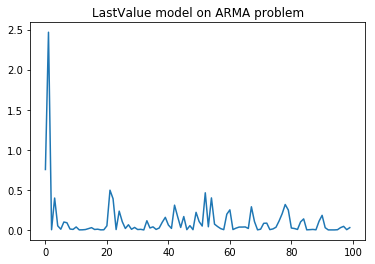

In [0]:
# create environment instance and specify loss
T = 100
p, q = 3, 3
environment = tigercontrol.environment("ARMA-v0")
x = environment.initialize(p, q)
mse = lambda y_true, y_pred: (y_true - y_pred)**2

# create controller
controller = tigercontrol.controllers("LastValue")
controller.initialize()

# run controller for T time-steps
results = []
for i in range(T):
    y_pred = controller.predict(x)
    y_true = environment.step()
    loss = mse(y_true, y_pred)
    results.append(loss)
    controller.update(y_true)
    x = y_true

# plot controller performance
plt.plot(results)
plt.title("LastValue controller on ARMA environment")
plt.show()


# The Environment and Controller Registry
Each of the Environment and Controller classes included in TigerControl are inserted into a global registry, which is dict from a unique string to the Environment/Controller class corresponding to the string. The registry supports versioning, so that multiple versions of a certain Environment/Controller can be referenced. For example, the id "ARMA-v0" is the registry id for version 0 of the ARMA environment. The previous example shows how to create instances of environment and controller via the corresponding registry ids. A comprehensive list of all Environment and Controller ids can be printed by printing out the keys of the global registries: environment_registry and controller_registry, as demonstrated below.

In [0]:
print(tigercontrol.environment_registry.list_ids())
print(tigercontrol.controllers_registry.list_ids())

['CartPole', 'CartPoleSwingup', 'CartPoleDouble', 'Kuka', 'KukaDiverse', 'Minitaur', 'HalfCheetah', 'Ant', 'Humanoid', 'LDS-Control', 'RNN-Control', 'LSTM-Control', 'Random', 'ARMA', 'SP500', 'UCIIndoor', 'Crypto', 'Unemployment', 'ENSO']
['LastValue', 'AutoRegressor', 'PredictZero', 'RNN', 'LSTM', 'KalmanFilter', 'ODEShootingController', 'LQR', 'MPPI', 'CartPoleNN']


# Creating and Registering Custom Controllers
In order to add a new algorithm to the registry, you must first implement a CustomController object that adheres to the specifications of the other TigerControl controllers. As long as your class inherits the tigercontrol CustomClass object and has the three core TigerControl Controller controllers implemented — *initialize*, *predict*, and *update* — the class will interface as expected with all the other features in the framework. These controllers are:

*   Initialize — initializes controller parameters and other local variables, and is called at the beginning of every environment run
*   Predict — a function that takes an input observation 'x' and returns a prediction which can depend on the parameters defined in initialize
*   Update — which takes the true label with respect to the last observed value 'x' and performs some correction over the initialized parameters.

The output of the predict controller will vary depending on the task of your controller. Below, we implement a trivial last-value controller named MyController.

In [0]:
class MyController(tigercontrol.CustomController):
  
  def initialize(self):
    pass
  
  def predict(self, x):
    return x
  
  def update(self, y_true):
    pass

TigerControl comes with a built in ```register_custom_controller``` controller that allows users to register controller classes with custom names.

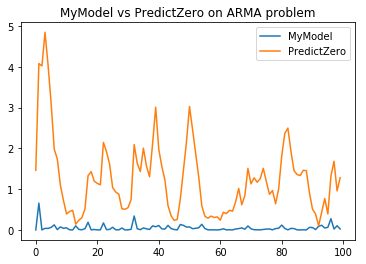

In [0]:
# add MyController to the controller registry
tigercontrol.register_custom_controller(MyController, "NameOfMyController")

# we can now use it as with any other controller
my_controller = tigercontrol.controllers("NameOfMyController")
my_controller.initialize()

# test controller on ARMA environment and compare to PredictZero
T = 100
p, q = 3, 3
environment = tigercontrol.environment("ARMA-v0")
x = environment.initialize(p, q)
mse = lambda y_true, y_pred: (y_true - y_pred)**2
pz_controller = tigercontrol.controllers("PredictZero")
pz_controller.initialize()

my_results = []
pz_results = []
for i in range(T):
    my_y_pred = my_controller.predict(x)
    pz_y_pred = pz_controller.predict(x)
    y_true = environment.step()
    my_loss = mse(y_true, my_y_pred)
    pz_loss = mse(y_true, pz_y_pred)
    my_results.append(my_loss)
    pz_results.append(pz_loss)
    my_controller.update(y_true)
    pz_controller.update(y_true)
    x = y_true

# plot controller performance
plt.plot(my_results, label="MyController")
plt.plot(pz_results, label="PredictZero")
plt.legend()
plt.title("MyController vs PredictZero on ARMA environment")
plt.show()


Our class can now be find in the registry as well. 

In [0]:
print(tigercontrol.controllers_registry.list_ids()[-1])

NameOfMyController


# The Experiment Class
The Experiment class should be thought of as a sort of engine that allows the automated combination of various controllers against various environments. It supports plotting the loss functions for the various (environment, controller) trials. It can either use precomputed results or recompute them with specified hyperparameters. Below, we demonstrate two ways to initialize experiment.

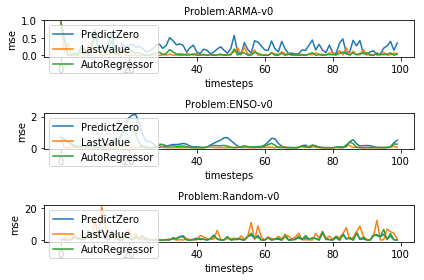

Average mse:
+-----------------+-------------+-------------+---------------+
| Environments\Controllers | PredictZero |  LastValue  | AutoRegressor |
+-----------------+-------------+-------------+---------------+
|     ARMA-v0     |  0.22052002 | 0.057029933 |   0.06765622  |
|     ENSO-v0     |  0.2731384  | 0.031695034 |   0.14695774  |
|    Random-v0    |  1.2548718  |  2.3389835  |   1.3408834   |
+-----------------+-------------+-------------+---------------+


In [3]:
from tigercontrol.experiments import Experiment

exp = Experiment()
exp.initialize(environments = ['ARMA', 'ENSO', 'Random'],
               controllers = ['PredictZero', 'LastValue', 'AutoRegressor'],
               use_precomputed = True)
exp.graph()
exp.scoreboard()

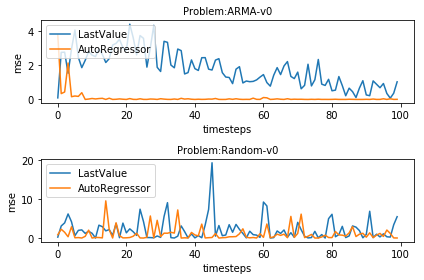

Average mse:
+-----------------+-----------+---------------+
| Environments\Controllers | LastValue | AutoRegressor |
+-----------------+-----------+---------------+
|     ARMA-v0     |  1.791285 |   0.09216989  |
|    Random-v0    | 2.1228893 |   1.0640942   |
+-----------------+-----------+---------------+


In [11]:
from tigercontrol.utils.optimizers import OGD

exp = Experiment()
exp.initialize(environments = {'ARMA' : {'p':4, 'q':2}, 'Random' : None},
               controllers = {'LastValue': None, 'AutoRegressor': {'optimizer': OGD}},
               use_precomputed = False, verbose = False, load_bar = False)
exp.graph()
exp.scoreboard()

# Random Seeding
As you may have observed from the beginning of the notebook, TigerControl utilizes seeding implemented by jax.random in order to enforce reproducibility of experiment results. By setting a global random key at the beginning of a program, right after tigercontrol is imported, the random number generators used in all the environments and controllers become deterministic. Below, we demonstrate how to reproduce the same experiment twice by calling set_key().

/usr/local/lib/python3.6/dist-packages/jax/numpy/linalg.py:58: UserWarning: numpy.linalg support is experimental and may cause silent failures or wrong outputs
  warnings.warn(_EXPERIMENTAL_WARNING)


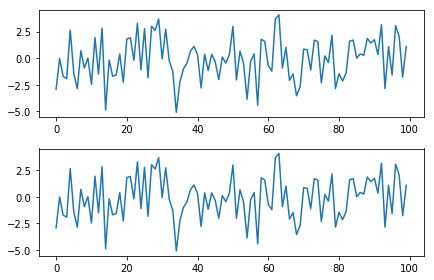

In [0]:
import jax.random as random
from tigercontrol.utils.random import generate_key, set_key

key = 2019 # arbitrary integer value
T = 100
n, m, d = 5, 1, 10
environment = tigercontrol.environment("LDS-Control-v0")

# set the key and run experiment once
set_key(key)
environment.initialize(n, m, d)
test_output = []
for t in range(T):
    u = random.normal(generate_key(),shape=(n,))
    test_output.append(environment.step(u))

# use the same key and run again
set_key(key)
environment.initialize(n, m, d)
test_output_2 = []
for t in range(T):
    u = random.normal(generate_key(),shape=(n,))
    test_output_2.append(environment.step(u))

# plot results
fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].plot(test_output)
ax[1].plot(test_output_2)

fig.tight_layout()
plt.show()

You are now ready to benchmark your algorithm of choice using TigerControl!